In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

#### Load data:

In [2]:
d, Nobs = 2000, 3000
X = sprandn(d, Nobs, 5e-2)
ξ_true = 3*sprandn(d, 1e-2)
ξ_true[1] = 3*randn()
y = [rand(Binomial(1, 1/(1+exp(-X[:,n]'ξ_true)))) for n in 1:Nobs];

#### Define prior:

In [3]:
σ02 = 1
prior = SS_prior(d, σ02);

#### Define model:

In [4]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

#### Define minibatch sampler:

In [6]:
mb_size = 100
weights_het = spzeros(d, Nobs)
@showprogress for i in 1:d 
    nzind = X[i,:].nzind
    weights_het[i,nzind] = abs.(X[i,nzind])./sum(abs.(X[i,nzind]))
end

prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)
@showprogress for i in 2:d 
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het[i,:], prob_het)
end
gs_list = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


#### Define output scheduler:

In [7]:
A_xi = ones(1,d)/d
A_hyp = ones(1,hyperparam_size(prior))/hyperparam_size(prior)

opf = projopf(A_xi, A_hyp, 1000)
opt = maxa_opt(5*10^5, 10^5)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

#### Define mbsampler + block Gibbs sampler list:

In [8]:
adapt_speed = "by_var"
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e3)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [9]:
ZZ_block_sample(my_model, outp, blocksampler, mstate);

10% attempts in 0.48 mins 
20% attempts in 0.91 mins 
Trimmed after 100000 bouncing attempts 


LoadError: [91mDimensionMismatch("dimensions must match")[39m

* Number of bounces:

In [53]:
zz_bounces = sum(mstate.n_bounces)
hyp_bounces = outp.opf.tcounter-sum(mstate.n_bounces)
@printf("ZZ bounces: %i, hyper bounces: %i", zz_bounces, hyp_bounces)

ZZ bounces: 1871996, hyper bounces: 182037

In [54]:
size(outp.opf.xi_skeleton,2)/outp.opt.max_attempts

0.04108066

In [55]:
post_mean_gzz = mstate.mu
# post_median_gzz = median(xi_samples,2);

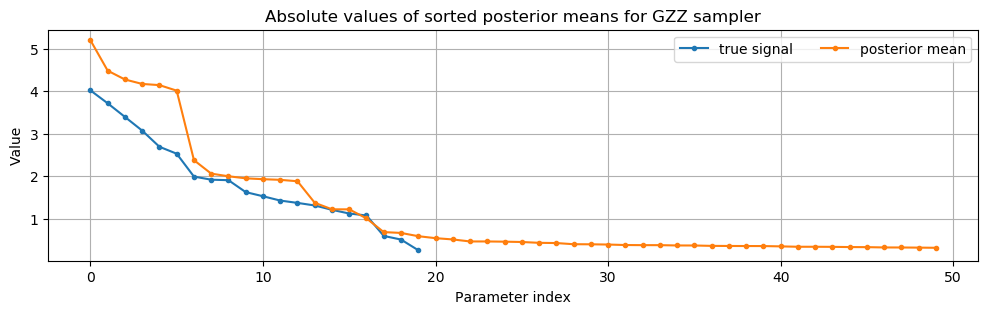

PyObject Text(24.00000000000002, 0.5, 'Value')

In [58]:
fig = figure(figsize=(12,3))
plot(sort(abs.(ξ_true.nzval), rev=true), "o-", markersize=3, label="true signal")
plot(sort(vec(abs.(post_mean_gzz)), rev=true)[1:50], "o-", markersize=3, label="posterior mean")
# plot(sort(vec(abs.(post_median_gzz)), rev=true)[1:50], "o-", markersize=3, label="posterior median")
grid(true)
title("Absolute values of sorted posterior means for GZZ sampler")
legend(ncol=3)
xlabel("Parameter index")
ylabel("Value")

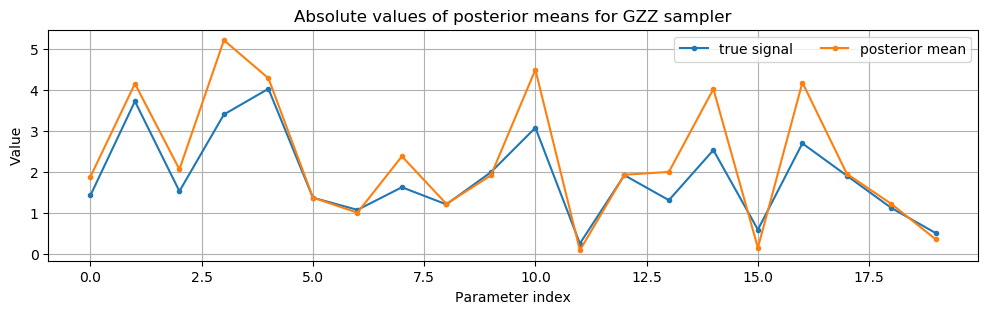

In [62]:
fig = figure(figsize=(12,3))
plot(abs.(ξ_true.nzval), "o-", markersize=3, label="true signal")
plot(vec(abs.(post_mean_gzz))[ξ_true.nzind], "o-", markersize=3, label="posterior mean")
grid(true)
title("Absolute values of posterior means for GZZ sampler")
legend(ncol=3)
xlabel("Parameter index")
ylabel("Value");